# Examine & plot all the dynamics field

- Plot surface pressure
- Plot wind vector (already regridded to lat-lon by wind_C2L.ipynb)
- Calculate and plot Lyaponuv
- Check wind magnitude

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cubedsphere as cs

# Minimum script to plot wind

In [17]:
datadir = '../../outputdata/regridded/'
ds_wind = xr.open_dataset(datadir+'C48L20_wind700.nc')
#ds_wind = xr.open_dataset(datadir+'C384L20_wind700.nc')
ds_wind

<xarray.Dataset>
Dimensions:  (x: 180, x_b: 181, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 -171.0 -169.0 -167.0 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
    lon_b    (y_b, x_b) int64 -180 -178 -176 -174 -172 -170 -168 -166 -164 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    u700     (y, x) float64 0.1535 0.1535 0.1535 0.1535 0.1535 0.1535 0.1535 ...
    v700     (y, x) float64 0.01408 0.01408 0.01408 0.01408 0.01408 0.01408 ...

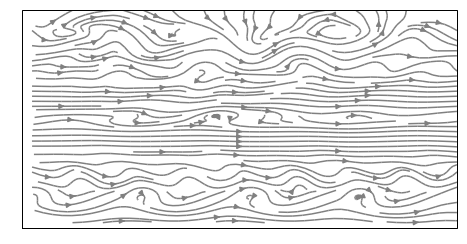

In [18]:
# steamplot() only works well with raw numpy arrays
lon, lat = [ds_wind['lon'].values,ds_wind['lat'].values]
u, v = [ds_wind['u700'].values,ds_wind['v700'].values]
    
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())

ax.streamplot(lon, lat, u, v,
              density=1.5, color='grey')

# Minimum script for Lyapunov exponent

In [2]:
def L_exponent(u, v, lat, dlat, dlon):
    s_lat = 110.574e3 * dlat
    s_lon = 111.320e3 * np.cos(lat/180*np.pi) * dlon
    du = (np.roll(u,1,axis=-1)-np.roll(u,-1,axis=-1))
    dv = (np.roll(v,1,axis=-2)-np.roll(v,1,axis=-2))
    L = (np.abs(du)+np.abs(dv))/(s_lon+s_lat)[:,np.newaxis]
    return L

In [20]:
L = L_exponent(u, v, lat[:,0], 2, 2)
#L = L_exponent(u, v, lat[:,0], 0.25, 0.25)
L.shape

(90, 180)

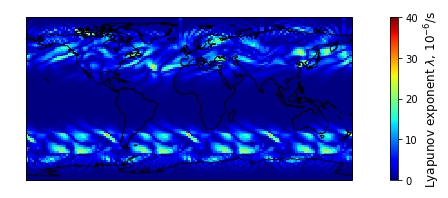

In [29]:
vmin, vmax = [0,40]

fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

im = ax.pcolormesh(lon,lat,L*1e6,cmap='jet',vmin=vmin, vmax=vmax)
#ax.set_title('day = {0}'.format(t-7), fontsize=12)

plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5,
             ticks=np.linspace(vmin,vmax,5)).\
             set_label("Lyapunov exponent $\lambda$, $10^{-6}$/s",fontsize=12)

# Minimum script for surface pressure

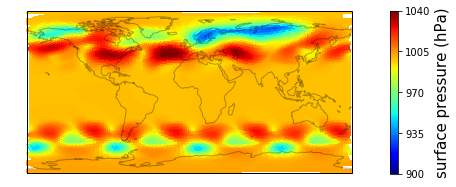

In [28]:
datadir = "/n/home03/zhuangjw/seasasfs/fromPleiades/output_FV3/" # Odyssey

ds = cs.open_FV3data(datadir+'C48/C48L20/',"atmos_daily").isel(time=-1)
#ds = cs.open_FV3data(datadir+'C384/C384L20/',"atmos_daily").isel(time=-1)

vmin,vmax = [900,1040]

dr = ds['ps']/100 # Pa to hPa
        
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.3)

im = cs.plotCS( dr, ds, ax, cmap='jet',vmin=vmin,vmax=vmax)

#ax.set_ylim([10,88]);#ax.set_xlim([-100,120])
#ax.set_title('C{0}L{1}'.format(Hres,Vres),fontsize=15)     

# provide a list of axes to let the colorbar span all those axes
fig.colorbar(im, ax=ax, orientation='vertical',
             shrink=0.5,ticks=np.linspace(vmin,vmax,5)).\
             set_label("surface pressure (hPa)",fontsize=15)

# Put them together to make plots for paper

## Read data & Proprecessing

In [2]:
# cubed-sphere PS field
datadir = "/n/home03/zhuangjw/seasasfs/fromPleiades/output_FV3/" # Odyssey

ds_p1 = cs.open_FV3data(datadir+'C48/C48L20/',"atmos_daily").isel(time=-1)
ds_p2 = cs.open_FV3data(datadir+'C384/C384L20/',"atmos_daily").isel(time=-1)

In [3]:
# lat-lon wind
datadir = '../../outputdata/regridded/'
ds_w1 = xr.open_dataset(datadir+'C48L20_wind700.nc')
ds_w2 = xr.open_dataset(datadir+'C384L20_wind700.nc')

In [4]:
# data set to numpy array
lon1, lat1, u1, v1 = [ds_w1[var].values for var in['lon','lat','u700','v700']]
lon2, lat2, u2, v2 = [ds_w2[var].values for var in['lon','lat','u700','v700']]

In [5]:
# Lyapunov exponent
from Lyapunov import Lyapunov
L1 = Lyapunov(u1, v1, lat1[:,0], 2, 2)
L2 = Lyapunov(u2, v2, lat2[:,0], 0.25, 0.25)
L1.shape, L2.shape

((90, 180), (720, 1440))

## Complete plotting script

In [33]:
# add latlon tick labels, no grid lines
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def latlon_ticks(ax, bottom=True, left=True):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='gray',alpha=1.0, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # tick content
    gl.xlocator = mticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135])
    gl.xlabel_style = {'size': 14}
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.ylabel_style = {'size': 14}
    
    # toggle 
    gl.xlabels_top = False
    gl.ylabels_right = False
    if bottom is not True:
        gl.xlabels_bottom = False
    if left is not True:
        gl.ylabels_left= False

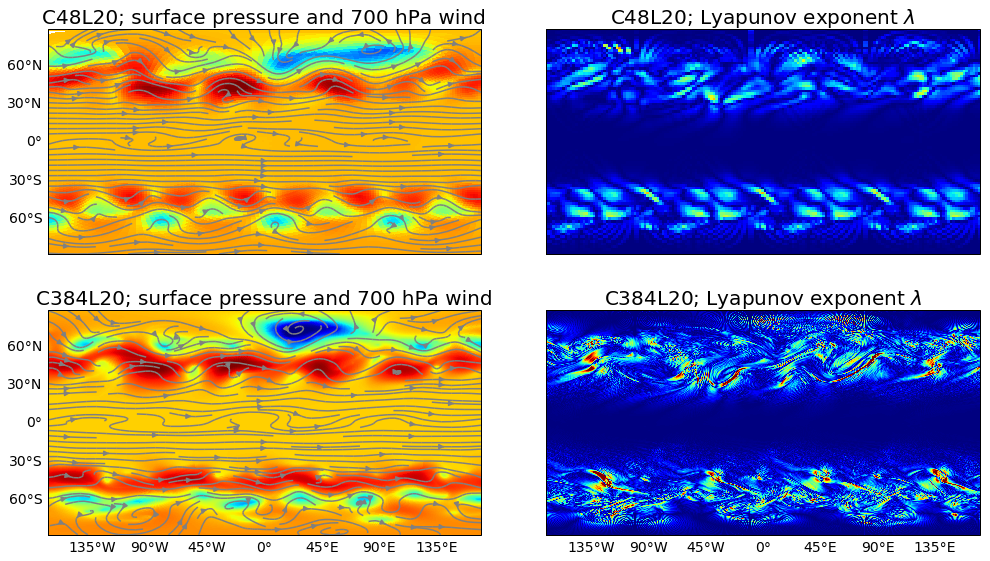

In [35]:
fig, axes = plt.subplots(2, 2, figsize=[14,8],
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

# plot surface pressure
vmin,vmax = [900,1040]
for ax,ds in zip([axes[0][0],axes[1][0]], [ds_p1,ds_p2]):
    dr = ds['ps']/100 # Pa to hPa
    im_p = cs.plotCS( dr, ds, ax, cmap='jet',vmin=vmin,vmax=vmax)
    ax.set_xlim(-170,170);ax.set_ylim(-88,88); # this is necessary for making subplot size fixed

    
# plot L exponent
vmin,vmax = [0,40]
for ax,lon,lat,L in zip([axes[0][1],axes[1][1]], [lon1,lon2], [lat1,lat2], [L1,L2]):
    im_L = ax.pcolormesh(lon, lat, L*1e6, cmap='jet',vmin=vmin, vmax=vmax)
    ax.set_xlim(-170,170);ax.set_ylim(-88,88);

# overlay wind
axes[0][0].streamplot(lon1, lat1, u1, v1, density=1.5, color='grey')
axes[1][0].streamplot(lon2, lat2, u2, v2, density=1.5, color='grey') # this takes very long!!

# adding description
titlesize = 20
axes[0][0].set_title('C48L20; surface pressure and 700 hPa wind',fontsize=titlesize)
axes[1][0].set_title('C384L20; surface pressure and 700 hPa wind',fontsize=titlesize)
axes[0][1].set_title('C48L20; Lyapunov exponent $\lambda$',fontsize=titlesize)
axes[1][1].set_title('C384L20; Lyapunov exponent $\lambda$',fontsize=titlesize)

# add lat-lon ticks
latlon_ticks(axes[0][0],bottom=False)
latlon_ticks(axes[1][1],left=False)
latlon_ticks(axes[1][0])

fig.tight_layout()
fig.savefig('all_dynamics.png',dpi=400)

Tweaking colorbar position in cartopy subplots is quite hard. Add them afterwards.

### Horizontal colorbar

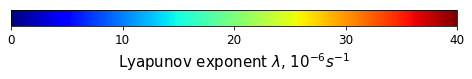

In [122]:
fig, ax = plt.subplots(1, 1, figsize=[8,0.3])

cb = fig.colorbar(im_L, ax, orientation='horizontal',ticks=np.linspace(0,40,5))
cb.set_label("Lyapunov exponent $\lambda$, $10^{-6} s^{-1}$",fontsize=15)
cb.ax.tick_params(labelsize=12)
fig.savefig('Lyapunov_colorbar.png',dpi=400, bbox_inches='tight')

# bbox_inches is necessary for saving the complete figure
# https://stackoverflow.com/questions/39013094/how-to-savefig-as-show-in-matplotlib-pyplot

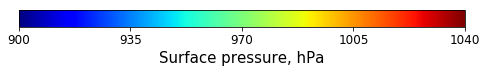

In [118]:
fig, ax = plt.subplots(1, 1, figsize=[8,0.3])

cb = fig.colorbar(im_p, ax, orientation='horizontal',ticks=np.linspace(900,1040,5))
cb.set_label("Surface pressure, hPa",fontsize=15)
cb.ax.tick_params(labelsize=12)
fig.savefig('PS_colorbar.png',dpi=400, bbox_inches='tight')

### Vertical colorbar

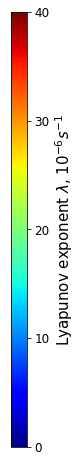

In [120]:
fig, ax = plt.subplots(1, 1, figsize=[0.3,8])

cb = fig.colorbar(im_L, ax, orientation='vertical',ticks=np.linspace(0,40,5))
cb.set_label("Lyapunov exponent $\lambda$, $10^{-6} s^{-1}$",fontsize=15)
cb.ax.tick_params(labelsize=12)

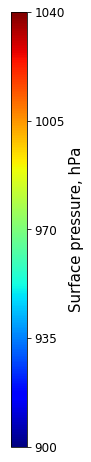

In [121]:
fig, ax = plt.subplots(1, 1, figsize=[0.3,8])

cb = fig.colorbar(im_p, ax, orientation='vertical',ticks=np.linspace(900,1040,5))
cb.set_label("Surface pressure, hPa",fontsize=15)
cb.ax.tick_params(labelsize=12)